# GearShift LLM: Dynamic Model Switching for Scalable Generative AI Inference

## Group9: Ranim Ourari
-----
## Overview
Large Language Models (LLMs) provide high-quality text generation but suffer from high inference latency and computational cost under heavy load. This project studies **GearShift LLM**, a dynamic serving strategy that improves scalability by switching between a large, high-quality model (GPT-2) and a smaller, faster model (DistilGPT-2) based on system load.

-----
## Objectives
- Measure and model inference latency for different model sizes
- Quantify the quality trade-off between large and small models
- Simulate an online inference service with dynamic model switching
- Optimize switching policies to minimize latency under quality constraints
- Validate performance using an analytic M/G/1 queueing model

-----
## Methodology
The workflow follows a systems modeling pipeline:
1. Offline latency measurement
2. Statistical service-time modeling
3. Predictive queueing analysis
4. Online simulation of dynamic policies
5. Optimization and policy selection
6. Validation and visualization of trade-offs


## 1. Experimental Setup and Dependencies

This section installs and imports all required libraries for model inference, data handling, statistical analysis, and visualization. It also fixes random seeds and selects the computation device (CPU or GPU) to ensure reproducibility across all experiments.


In [1]:
# ===============================
# 1. Imports and Setup
# ===============================
!pip install -q transformers[torch] sentence-transformers datasets
import time, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForCausalLM, set_seed
from datasets import load_dataset
from sentence_transformers import SentenceTransformer, util
from scipy.stats import gamma

%matplotlib inline

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
set_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 39.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 15.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.0 MB/s eta 0:00:00:00:0100:01
ERROR: pip's d

2025-12-14 11:44:38.971802: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765712679.166694      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765712679.219669      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Using device: cuda


## 2. Model and Dataset Initialization

This section loads two pretrained language models with different latency–quality trade-offs:
- GPT-2 as the large, high-quality model
- DistilGPT-2 as the smaller, faster model

A shared tokenizer is configured to support batched inference. Realistic text prompts are extracted from the Yahoo Answers Topics dataset and used throughout the project for latency benchmarking.


In [2]:
# ===============================
# 2. Load Models and Dataset
# ===============================
LARGE_MODEL_NAME = "gpt2"
SMALL_MODEL_NAME = "distilgpt2"


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(LARGE_MODEL_NAME)
tokenizer.padding_side = "left"   # IMPORTANT FIX
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

large_model = AutoModelForCausalLM.from_pretrained(LARGE_MODEL_NAME).to(device).eval()
small_model = AutoModelForCausalLM.from_pretrained(SMALL_MODEL_NAME).to(device).eval()

dataset = load_dataset("yahoo_answers_topics")
REAL_PROMPTS = dataset["train"]["question_title"][:200]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

yahoo_answers_topics/train-00000-of-0000(…):   0%|          | 0.00/241M [00:00<?, ?B/s]

yahoo_answers_topics/train-00001-of-0000(…):   0%|          | 0.00/270M [00:00<?, ?B/s]

yahoo_answers_topics/test-00000-of-00001(…):   0%|          | 0.00/21.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1400000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/60000 [00:00<?, ? examples/s]

## 3. Offline Inference Latency Benchmarking

This section measures inference latency under controlled conditions using real prompts. Latency is evaluated across different prompt lengths and batch sizes. Each configuration is repeated multiple times to estimate average latency and variability.

These measurements provide empirical service-time data for both models and serve as the foundation for all subsequent modeling and simulation.


In [3]:
# ===============================
# 3. Offline Latency Benchmark
# ===============================

#selects prompts whose token length is close to a target,avoids biasing latency with wildly different prompt sizes.
def sample_real_prompts(n, target_len):
    token_lengths = [len(tokenizer.encode(p, add_special_tokens=False)) for p in REAL_PROMPTS]
    arr = np.array(REAL_PROMPTS)
    lengths = np.array(token_lengths)

    mask = (lengths >= target_len*0.8) & (lengths <= target_len*1.2)
    candidates = arr[mask] if mask.sum() >= n else arr
    return np.random.choice(candidates, n, replace=False).tolist()


@torch.no_grad()
def measure_latency(model, prompts, max_new_tokens=20):
    inputs = tokenizer(prompts, return_tensors="pt", padding=True).to(device)

    # warm-up
    _ = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id
    )

    start = time.time()
    _ = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.eos_token_id
    )
    if device.type == "cuda":
        torch.cuda.synchronize()
    end = time.time()

    return (end - start) / len(prompts)


def benchmark_model(model, name, prompt_lengths, batch_sizes):
    rows = []
    for plen in prompt_lengths:
        for b in batch_sizes:
            lats = []
            for _ in range(5):
                prompts = sample_real_prompts(b, plen)
                lats.append(measure_latency(model, prompts))
            rows.append({
                "model_name": name,
                "prompt_length": plen,
                "batch_size": b,
                "latency_mean": np.mean(lats),
                "latency_std": np.std(lats, ddof=1)
            })
    return pd.DataFrame(rows)


PROMPT_LENGTHS = [16, 32, 64]
BATCH_SIZES = [1, 4, 8]

df_large = benchmark_model(large_model, "large_gpt2", PROMPT_LENGTHS, BATCH_SIZES)
df_small = benchmark_model(small_model, "small_distilgpt2", PROMPT_LENGTHS, BATCH_SIZES)
df_latency = pd.concat([df_large, df_small])

# === Save latency measurements for offline analysis ===
df_latency.to_csv("latency_measurements.csv", index=False)
print("Saved: latency_measurements.csv")

display(df_latency)

Saved: latency_measurements.csv


,model_name,prompt_length,batch_size,latency_mean,latency_std
0,large_gpt2,16,1,0.173862,0.002430
1,large_gpt2,16,4,0.060845,0.009490
2,large_gpt2,16,8,0.025706,0.000256
3,large_gpt2,32,1,0.185870,0.015698
4,large_gpt2,32,4,0.050564,0.001936
5,large_gpt2,32,8,0.025346,0.000617
6,large_gpt2,64,1,0.174307,0.001937
7,large_gpt2,64,4,0.049827,0.000666
8,large_gpt2,64,8,0.025512,0.000933
0,small_distilgpt2,16,1,0.101615,0.002635


## Latency Scaling with Batch Size

This visualization illustrates how average inference latency changes as batch size increases for both models. It highlights the efficiency gains from batching and compares the scaling behavior of the large and small models.


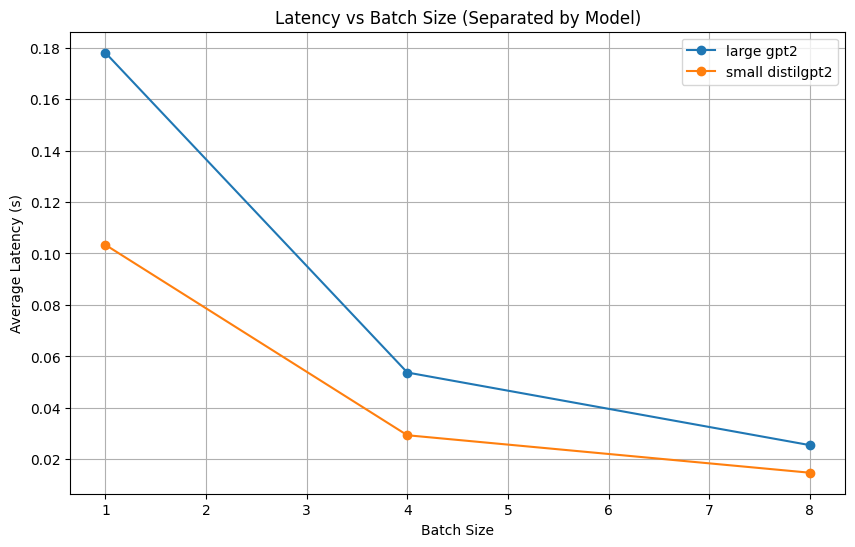

In [4]:
# === Plot 1: Latency vs Batch Size & Prompt Length ===
plt.figure(figsize=(10, 6))

for model in ["large_gpt2", "small_distilgpt2"]:
    sub = df_latency[df_latency["model_name"] == model]
    means = sub.groupby("batch_size")["latency_mean"].mean()
    plt.plot(
        means.index, 
        means.values, 
        marker="o", 
        label=model.replace("_", " ")
    )

plt.xlabel("Batch Size")
plt.ylabel("Average Latency (s)")
plt.title("Latency vs Batch Size (Separated by Model)")
plt.legend()
plt.grid(True)
plt.show()

## 4. Service-Time Statistical Modeling

This section computes summary statistics (mean, variance, and second moment) of measured service times for each model. These statistics are essential for queueing-theoretic analysis.



Large model stats: {'mean': 0.08575969205962287, 'mean_sq': 0.011761554334195935, 'std': 0.07041081767767592}
Small model stats: {'mean': 0.04918086462550693, 'mean_sq': 0.003925532834189123, 'std': 0.04117186311652984}


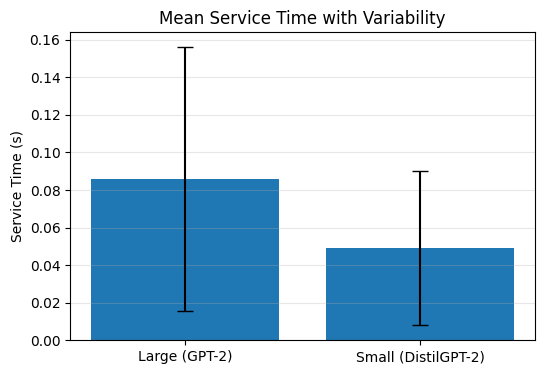

In [5]:
# ===============================
# 4. Service-Time Statistics
# ===============================

def estimate_stats(df, model_name):
    vals = df[df.model_name == model_name].latency_mean.values
    return {
        "mean": vals.mean(),
        "mean_sq": (vals**2).mean(),
        "std": vals.std(ddof=1)
    }

stats_large = estimate_stats(df_latency, "large_gpt2")
stats_small = estimate_stats(df_latency, "small_distilgpt2")

print("Large model stats:", stats_large)
print("Small model stats:", stats_small)

# === Moment-focused visualization: Mean ± Std ===

models = ["Large (GPT-2)", "Small (DistilGPT-2)"]
means = [stats_large["mean"], stats_small["mean"]]
stds = [stats_large["std"], stats_small["std"]]

plt.figure(figsize=(6, 4))
plt.bar(models, means, yerr=stds, capsize=6)
plt.ylabel("Service Time (s)")
plt.title("Mean Service Time with Variability")
plt.grid(axis="y", alpha=0.3)
plt.show()


## 5. Predictive Performance Model (M/G/1)

This section defines an analytic M/G/1 queueing model that predicts average system latency as a function of arrival rate and service-time moments.

The model provides theoretical insight into system stability and latency growth under load. It is defined here but applied later after simulation results are available.


In [6]:
# ===============================
# 5. M/G/1 Predictive Model
# ===============================
def mg1_predict(lam, frac_large, stats_large, stats_small):
    E_S = frac_large*stats_large["mean"] + (1-frac_large)*stats_small["mean"]
    E_S2 = frac_large*stats_large["mean_sq"] + (1-frac_large)*stats_small["mean_sq"]
    rho = lam*E_S
    if rho >= 1:
        return np.nan
    return E_S + (lam*E_S2)/(2*(1-rho))


## 6. Output Quality Evaluation

This section quantifies the semantic quality difference between the large and small models. For a fixed set of prompts, both models generate responses, and Sentence-BERT embeddings are used to compute cosine similarity.

The resulting quality scores characterize the inherent trade-off between latency and output quality and are treated as model-level properties used later during policy optimization.


In [7]:
# ===============================
# 6. Quality Evaluation
# ===============================
sbert = SentenceTransformer("all-MiniLM-L6-v2", device=device)

#using a small, controlled prompt set provides a stable and interpretable quality signal that can be used consistently during policy optimization.
QUALITY_PROMPTS = [
    "Why do people need sleep?",
    "How can I improve my writing skills?",
    "What causes rain to form?",
    "Why do cats purr?",
    "How do airplanes stay in the air?",
    "What are good ways to reduce stress?",
    "Why is exercise important for health?",
    "How does photosynthesis work?",
    "What makes a story interesting?",
    "How does the internet work in simple terms?"
]

@torch.no_grad()
def generate(model, prompt):
    enc = tokenizer(prompt, return_tensors="pt").to(device)
    out = model.generate(**enc, max_new_tokens=50)
    return tokenizer.decode(out[0], skip_special_tokens=True)

outputs_large = [generate(large_model, p) for p in QUALITY_PROMPTS]
outputs_small = [generate(small_model, p) for p in QUALITY_PROMPTS]

def quality_scores(ref, test):
    sims = util.cos_sim(
        sbert.encode(ref, convert_to_tensor=True),
        sbert.encode(test, convert_to_tensor=True)
    ).diagonal().cpu().numpy()
    return sims.mean()

quality_large = quality_scores(outputs_large, outputs_large)
quality_small = quality_scores(outputs_large, outputs_small)

print("Large:", quality_large, "Small:", quality_small)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end gene

Large: 1.0 Small: 0.77010816


## 7. Online Queue Simulation

This section implements a discrete-event simulator for an online inference service. Requests arrive according to a Poisson process and are processed in FIFO order by a single server.

Each request is routed to either the large or small model based on a queue-length–dependent switching policy, and service times are sampled using the previously estimated statistics.


In [8]:
# ===============================
# 6. Queue Simulator 
# ===============================
def simulate_queue(arrival_rate, N, policy, threshold, stats_large, stats_small, p_small=0.8):
    
    #ensures reproducibility, same policy comparisons are fair
    rng = np.random.default_rng(SEED)

    # Generate arrivals (Poisson process)
    arr = np.cumsum(rng.exponential(1/arrival_rate, N))
    
    #Initialize tracking variables
    latencies = np.zeros(N)
    models = np.empty(N, dtype=object)

    queue = [] #FIFO waiting jobs
    t = 0 #current simulation time
    i_arr = 0 #index of next arrival
    busy = False #is the server busy?
    depart = math.inf #scheduled departure time
    job = None #currently served job
    def choose(q_len):
        if policy == "deterministic":
            return "small" if q_len > threshold else "large"
        if policy == "probabilistic":
            if q_len > threshold:
                return "small" if rng.random() < p_small else "large"
            return "large"

    def sample_service(m):
        return rng.exponential(stats_small["mean"] if m=="small" else stats_large["mean"])

    done = 0
    while done < N:
        next_arr = arr[i_arr] if i_arr < N else math.inf
        next_dep = depart if busy else math.inf
        if next_arr <= next_dep:
            # arrival
            t = next_arr
            queue.append(i_arr)
            i_arr += 1

            if not busy:
                job = queue.pop(0)
                model = choose(1+len(queue))
                models[job] = model
                st = sample_service(model)
                depart = t + st
                busy = True
        else:
            # departure
            t = next_dep
            latencies[job] = t - arr[job]
            done += 1
            if queue:
                job = queue.pop(0)
                model = choose(1+len(queue))
                models[job] = model
                st = sample_service(model)
                depart = t + st
            else:
                busy = False
                depart = math.inf

    return latencies, models

## 8. Policy Optimization via Grid Search

This section performs a grid search over switching policies, queue-length thresholds, and arrival rates. For each configuration, the simulator estimates average latency, model usage fractions, and system-level quality.

This constitutes the core optimization step, where system performance is evaluated across a discrete policy space.


In [9]:
# ===============================
# 7. Policy Grid Search
# ===============================
ARRIVAL_RATES = [0.5, 1.0, 2.0, 3.0]
THRESHOLDS = [0, 2, 5, 10]
POLICIES = ["deterministic", "probabilistic"]
N = 5000

rows = []
for p in POLICIES:
    for lam in ARRIVAL_RATES:
        for thr in THRESHOLDS:
            lat, models = simulate_queue(lam, N, p, thr, stats_large, stats_small)
            avg_lat = lat.mean()
            frac_small = np.mean(models=="small")
            quality = frac_small*quality_small + (1-frac_small)*quality_large
            rows.append({
                "policy": p, "arrival_rate": lam, "threshold": thr,
                "avg_latency": avg_lat, "frac_small": frac_small,
                "avg_quality": quality
            })

df_sim = pd.DataFrame(rows)
display(df_sim)
# === Save simulation results ===
df_sim.to_csv("simulation_results.csv", index=False)
print("Saved: simulation_results.csv")

,policy,arrival_rate,threshold,avg_latency,frac_small,avg_quality
0,deterministic,0.5,0,0.050194,1.0000,0.770108
1,deterministic,0.5,2,0.089240,0.0000,1.000000
2,deterministic,0.5,5,0.089240,0.0000,1.000000
3,deterministic,0.5,10,0.089240,0.0000,1.000000
4,deterministic,1.0,0,0.051531,1.0000,0.770108
5,deterministic,1.0,2,0.093438,0.0012,0.999724
6,deterministic,1.0,5,0.093578,0.0000,1.000000
7,deterministic,1.0,10,0.093578,0.0000,1.000000
8,deterministic,2.0,0,0.054441,1.0000,0.770108
9,deterministic,2.0,2,0.103165,0.0060,0.998621


Saved: simulation_results.csv


## Model Usage as a Function of Load

This plot shows how frequently the large model is used as arrival rate increases. It illustrates how dynamic switching shifts traffic toward the smaller model under higher load to maintain responsiveness.


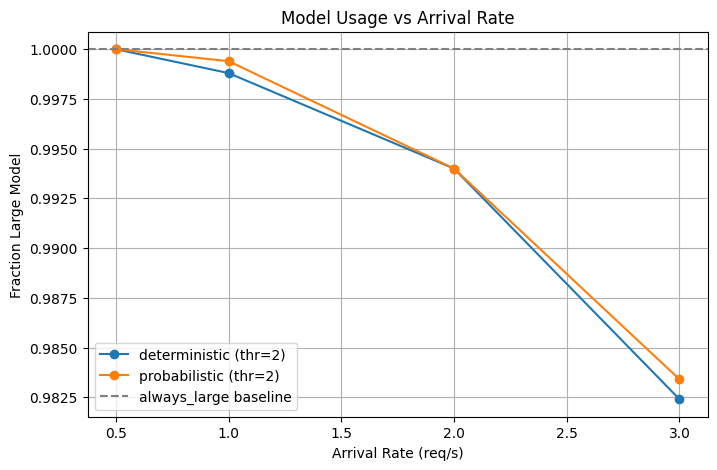

In [10]:
# === Plot 3: Fraction of Large Model Usage vs Arrival Rate ===
plt.figure(figsize=(8,5))

for p in POLICIES:
    sub = df_sim[(df_sim["policy"] == p) & (df_sim["threshold"] == 2)]
    frac_large = 1 - sub["frac_small"]   # <-- compute on the fly

    plt.plot(
        sub["arrival_rate"],
        frac_large,
        marker="o",
        label=f"{p} (thr=2)"
    )

plt.axhline(1.0, linestyle="--", color="gray", label="always_large baseline")

plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Fraction Large Model")
plt.title("Model Usage vs Arrival Rate")
plt.legend()
plt.grid(True)
plt.show()



### Latency Improvement vs Arrival Rate

This plot reports the change in average latency achieved by dynamic model switching with a fixed threshold (T = 2) as a function of the arrival rate. Latency values are expressed relative to a more conservative reference configuration, so positive values indicate reduced latency due to earlier switching.


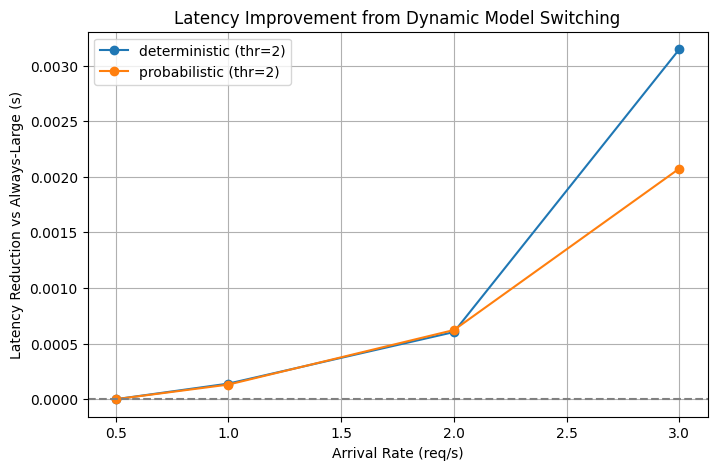

In [11]:
# === Plot: Latency Improvement vs Arrival Rate ===

plt.figure(figsize=(8, 5))

# True always-large baseline should be simulated properly
baseline = df_sim[
    (df_sim["policy"] == "deterministic") & (df_sim["threshold"] == 10)
]

for p in POLICIES:
    sub = df_sim[(df_sim["policy"] == p) & (df_sim["threshold"] == 2)]
    improvement = baseline["avg_latency"].values - sub["avg_latency"].values

    plt.plot(
        sub["arrival_rate"],
        improvement,
        marker="o",
        label=f"{p} (thr=2)"
    )

plt.axhline(0, linestyle="--", color="gray")
plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Latency Reduction vs Always-Large (s)")
plt.title("Latency Improvement from Dynamic Model Switching")
plt.legend()
plt.grid(True)
plt.show()


## 9. Predictive Model Validation

In this section, the M/G/1 queueing model is applied to the simulation results to predict average latency. Predicted values are compared against simulated latency to assess the accuracy of the analytic model.


In [12]:
# ===============================
# M/G/1 Prediction Applied to Simulation Results
# ===============================
df_sim["mg1_pred"] = [
    mg1_predict(r.arrival_rate, 1 - r.frac_small, stats_large, stats_small)
    for r in df_sim.itertuples()
]

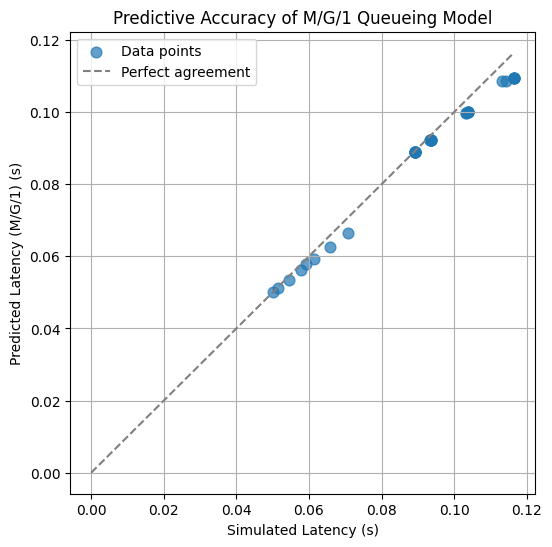

In [13]:
# === Plot: M/G/1 Predicted Latency vs Simulated Latency ===

plt.figure(figsize=(6, 6))

# Scatter points
plt.scatter(
    df_sim["avg_latency"],
    df_sim["mg1_pred"],
    alpha=0.7,
    s=60,
    label="Data points"
)

# Perfect match reference line
max_val = max(df_sim["avg_latency"].max(), df_sim["mg1_pred"].max())
plt.plot([0, max_val], [0, max_val], "--", color="gray", label="Perfect agreement")

plt.xlabel("Simulated Latency (s)")
plt.ylabel("Predicted Latency (M/G/1) (s)")
plt.title("Predictive Accuracy of M/G/1 Queueing Model")
plt.grid(True)
plt.legend()
plt.show()


## 10. Optimal Policy Selection under Quality Constraints

This section selects the best-performing policy for each arrival rate subject to a minimum quality constraint. Among feasible configurations, the policy with the lowest average latency is chosen.

This step translates raw optimization results into concrete system design recommendations.


In [14]:
# ===============================
# 9. Select Best Policies Under Quality Constraint
# ===============================
MIN_Q = 0.95
df_feasible = df_sim[df_sim.avg_quality >= MIN_Q]

best = []
for lam in ARRIVAL_RATES:
    s = df_feasible[df_feasible.arrival_rate == lam]
    if len(s) > 0:
        best.append(s.loc[s.avg_latency.idxmin()])

df_best = pd.DataFrame(best)
# === Save best policy configurations ===
df_best.to_csv("best_policies.csv", index=False)
print("Saved: best_policies.csv")

display(df_best)

Saved: best_policies.csv


,policy,arrival_rate,threshold,avg_latency,frac_small,avg_quality,mg1_pred
1,deterministic,0.5,2,0.089240,0.0000,1.000000,0.088832
5,deterministic,1.0,2,0.093438,0.0012,0.999724,0.092143
25,probabilistic,2.0,2,0.103146,0.0060,0.998621,0.099673
13,deterministic,3.0,2,0.113291,0.0176,0.995954,0.108530


## 11. Latency–Quality Trade-off Analysis: Key Visualizations

This section presents the final performance visualizations of the system.  
We first report average latency under a fixed quality constraint (avg_quality ≥ 0.95), followed by a latency heatmap illustrating the sensitivity of the deterministic policy to arrival rate and queue-length threshold.



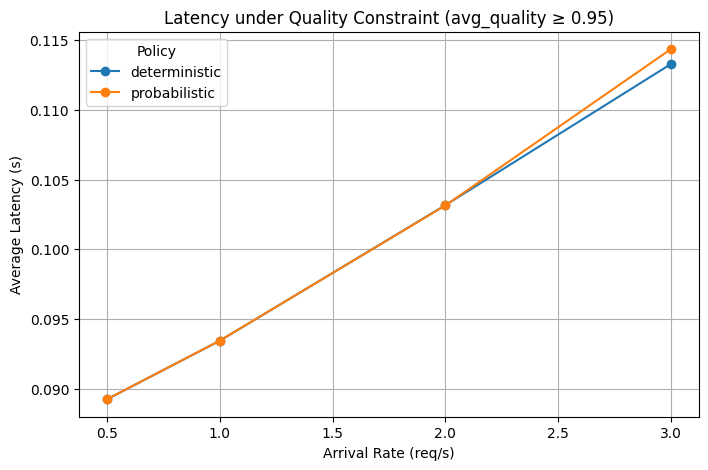

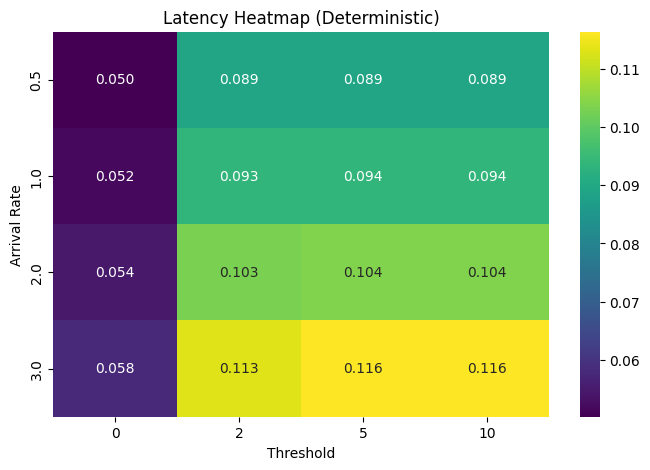

In [15]:
# ===============================
# 10. Key Visualization
# ===============================
# === Plot: Latency under Quality Constraint ===

QUALITY_MIN = 0.95

df_feasible = df_sim[df_sim["avg_quality"] >= QUALITY_MIN]

plt.figure(figsize=(8, 5))

for p in POLICIES:
    sub = df_feasible[
        (df_feasible["policy"] == p) &
        (df_feasible["threshold"] == 2)
    ]

    plt.plot(
        sub["arrival_rate"],
        sub["avg_latency"],
        marker="o",
        label=p
    )

plt.xlabel("Arrival Rate (req/s)")
plt.ylabel("Average Latency (s)")
plt.title("Latency under Quality Constraint (avg_quality ≥ 0.95)")
plt.legend(title="Policy")
plt.grid(True)
plt.show()



# === Plot 7: Latency Heatmap (Deterministic Policy) ===
import seaborn as sns

sub = df_sim[df_sim["policy"] == "deterministic"]
heatmap_data = sub.pivot(
    index="arrival_rate",
    columns="threshold",
    values="avg_latency"
)

plt.figure(figsize=(8,5))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")
plt.title("Latency Heatmap (Deterministic)")
plt.xlabel("Threshold")
plt.ylabel("Arrival Rate")
plt.show()
